# Microarray Analysis of Gene Expression. Differential Analysis

The differential expression analysis aims at identifying the genes whose expression levels change between two sample groups. For the differential expression (DE) analysis, we use R package Limma as part of a customised expression pipeline.

At this point, expression and clinical datasets are expected to be clean/preprocessed, containing the same samples and in the same order and ready to use in limma. Do a previous preprocessing if needed.



### Read clinical and expression datasets. 

To have an idea on how the data look like. It is not neccesary to load here previously if you are providing paths to these datasets in the DE step.

In [1]:
datasets=load("/mnt/data/GWES/Microarray/output/GSE15222/objects.RData")
datasets

[1] "expr.log.complete" "clinicalset"

In [2]:
dim(clinicalset)
head(clinicalset,n=3)

[1] 336   5

,sex,age,diagnosis,APOEgeno,APOEgroup
,<chr>,<dbl>,<chr>,<int>,<chr>
GSM388327,Female,85,Case,34,Group4
GSM388385,Male,77,Case,34,Group4
GSM388383,Female,90,Case,44,Group4


In [3]:
dim(expr.log.complete)
head(expr.log.complete,n=3L)

[1] 9592  363

,GSM225652,GSM225662,GSM225664,GSM225665,GSM225666,GSM225667,GSM225668,GSM225669,GSM225670,GSM225671,...,GSM388388,GSM388389,GSM388390,GSM388391,GSM388392,GSM388393,GSM388394,GSM388395,GSM388396,GSM388397
GI_10047091-S,12.468587,12.367136,12.931349,11.936586,12.349515,12.343600,12.419823,12.394077,12.374868,12.443017,...,10.949267,11.462465,11.847216,11.361139,8.971136,11.851911,11.358655,11.891294,11.821033,11.625528
GI_10047093-S,7.081468,5.795233,6.246219,6.624542,6.738895,6.640043,7.053141,6.577844,6.751791,6.971065,...,6.477515,6.945243,7.193346,6.512597,5.958902,6.968007,6.916382,7.561493,7.716903,7.725393
GI_10047103-S,9.756334,9.673358,9.813577,10.099799,9.729754,9.819325,9.883315,10.398109,9.862523,10.392574,...,10.829192,10.351871,10.271808,9.808778,10.076091,10.106496,10.000358,10.270667,10.529364,10.520075


**Note: It is very important that clinical and expression datasets have the same samples and maintain the same order.** rownames(clinicalset) or sample name/ID column must be in the same order as colnames(expressionset)

Suggested function to keep the same samples in both datasets and in the same order:

In [4]:
# Keep the same samples in both datasets and in the same order
# 1st param: clinical dataframe
# 2nd param: expression dataframe
# returns a list containing the new clinicalset as first element and new expression set as the second element
# optional: create rownames in expressionset as a combination of conditions from clinicalset. Very useful for heatmaps in DE
keepCommonSamplesDF_function<-function(clinicalset,expression.df){  #,clinical.match
    merged.df=merge(t(expression.df),clinicalset,by= "row.names")
    # optional - customise
    rownames(merged.df)<-paste(merged.df$Row.names,merged.df$diagnosis,merged.df$APOEgroup,sep="_")
    ncols<-ncol(merged.df)-ncol(clinicalset) # remove columns from clinical data, bear in mind the clinical.match column
    new.expr<-t(merged.df[, 2:ncols] ) # 1st column is Row.names that merge command creates
    from=ncols+1
    to=dim(merged.df)[2]
    new.clinicalset<-merged.df[, from:to]
    return(list(new.clinicalset,new.expr))
}

In [5]:
# call keepCommonSamplesDF function to get clinical and expression sets containing matching samples
sets=keepCommonSamplesDF_function(clinicalset,expr.log.complete)
clinicalset.common=sets[[1]]
dim(clinicalset.common)
expr.common=sets[[2]]
dim(expr.common)

[1] 336   5

[1] 9592  336

Check the datasets are correct and keepCommonSamplesDF function fits your needs.

In [6]:
head(clinicalset.common,n=3)
head(expr.common,n=3)

,sex,age,diagnosis,APOEgeno,APOEgroup
,<chr>,<dbl>,<chr>,<int>,<chr>
GSM225652_Control_Group3,Male,85,Control,33,Group3
GSM225662_Control_Group3,Male,85,Control,33,Group3
GSM225664_Control_Group3,Male,79,Control,33,Group3


,GSM225652_Control_Group3,GSM225662_Control_Group3,GSM225664_Control_Group3,GSM225665_Control_Group3,GSM225666_Control_Group3,GSM225667_Control_Group3,GSM225668_Control_Group3,GSM225670_Control_Group4,GSM225671_Control_Group3,GSM225672_Control_Group3,...,GSM388388_Case_Group4,GSM388389_Case_Group3,GSM388390_Case_Group2,GSM388391_Case_Group4,GSM388392_Case_Group3,GSM388393_Case_Group4,GSM388394_Case_Group4,GSM388395_Case_Group4,GSM388396_Case_Group4,GSM388397_Case_Group4
GI_10047091-S,12.468587,12.367136,12.931349,11.936586,12.349515,12.343600,12.419823,12.374868,12.443017,11.133454,...,10.949267,11.462465,11.847216,11.361139,8.971136,11.851911,11.358655,11.891294,11.821033,11.625528
GI_10047093-S,7.081468,5.795233,6.246219,6.624542,6.738895,6.640043,7.053141,6.751791,6.971065,5.909498,...,6.477515,6.945243,7.193346,6.512597,5.958902,6.968007,6.916382,7.561493,7.716903,7.725393
GI_10047103-S,9.756334,9.673358,9.813577,10.099799,9.729754,9.819325,9.883315,9.862523,10.392574,10.088680,...,10.829192,10.351871,10.271808,9.808778,10.076091,10.106496,10.000358,10.270667,10.529364,10.520075


### Differential Expression

In [7]:
# Import differential expression functions
source("scripts/diffExpressionPipeline.R")

**Call diff_analysis_function from the pipeline scrips.**

This function performs a differential analysis over the dataset supplied and it is customisable via the input parameters. Specify the conditions you want to do the contrast on. 
It is possible to perform de DE over a subset of the data. **Read the user manual to know more. I haven't written more info**

- 1st parameter: path where the clinical and expression sets are stored. Optional if you supply the sets as R dataframes
- 2nd parameter: clinicalset dataframe or file name that points to the dataframe in the provided path
- 3rd parameter: expression dataframe or file name that points to the dataframe in the provided path. Probes as rows, samples as columns. Rownames(clinicalset) must be in the same order as names(expressionset)
- 4-7th parameters: parameters used in limma for Diferential Expression. 4th and 5th will be used as contrast: condition1 - condition2 (i.e. case-control) 
    - 4th: first condition that satisfied the first group your are comparing. i.e "case"
    - 5th: second condition that satisfied the second group your are comparing. i.e "control"
    - 6th: column name from the clinical dataframe containing the condition 
    - 7th: optional - character string separated by commas indicating other variables (column names from clinical data) to include as covariates in limma (to adjust for these covariates excluding their effect)
- 8-9th parameters are optional and needed if you want to do diff analysis on a subset of the original data (i.e. only in females)
    - 8th parameter: column name from the clinical dataframe to be used to subset both clinical and expr dataframes
    - 9th parameter: value of column name from the clinical df to be used to subset
- 10th parameter: optional - output path to store limma table as a result (default to current directory)
- 11th parameter: optional - output file name
- 12th parameter: platform/chip 
- 13th parameter: optional - number of probes to be represented in the heatmap plot (probes are ordered by best p value; default 50)

**Case versus Control - corrected for age and sex**


####  Case  versus  Control  ####


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  336 5
dim(expr)  9592 336
Subseting datasets to keep those subjects belonging to provided conditions:  Case  and  Control
dim(clinical.subset)  336 5
dim(expr.subset)  9592 336

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]+clinicalset[[DE.covariates[2]]]

design matrix: 
  Case Control clinicalset..DE.covariates.1...Male
1    0       1                                   1
2    0       1                                   1
3    0       1                                   1
  clinicalset..DE.covariates.2...
1                              85
2                              85
3                              79


contrast:  Case-Control 


limma topTable: 
                   logFC       CI.L       CI.R  AveExpr         t      P.Value    adj.P.Val        B
GI_23312375-A -1.1525001 -1.3260708 -0.9789294 6.340362 -13.06101 8.010067e-32 7.683257e-28 61.40136
GI_4585642-S   0.9020393  0.7653437  1.0387349 7.028273  12.98024 

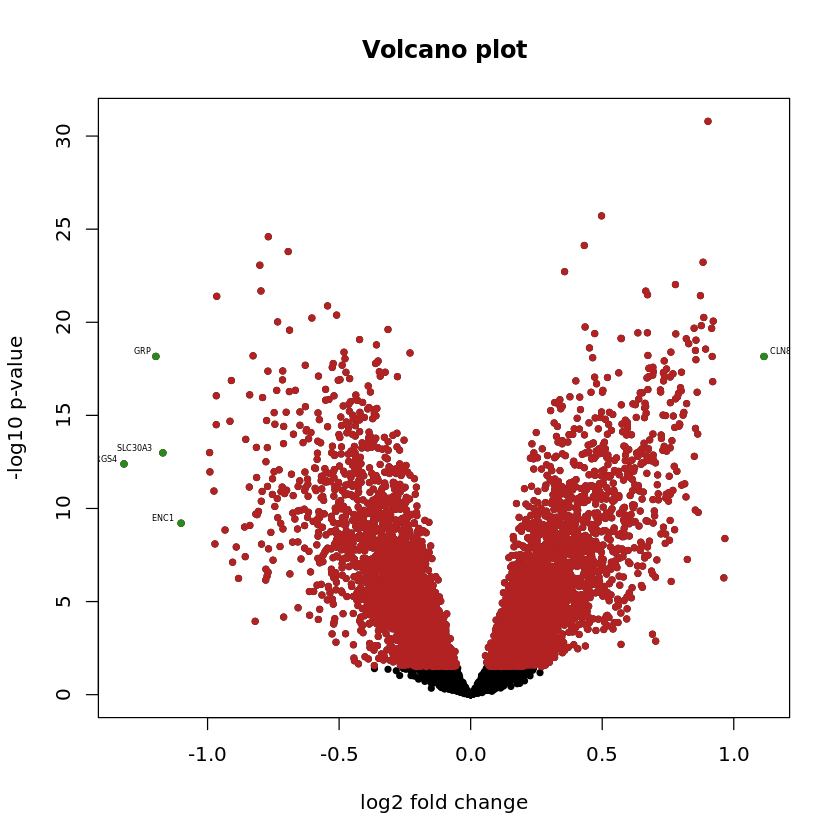

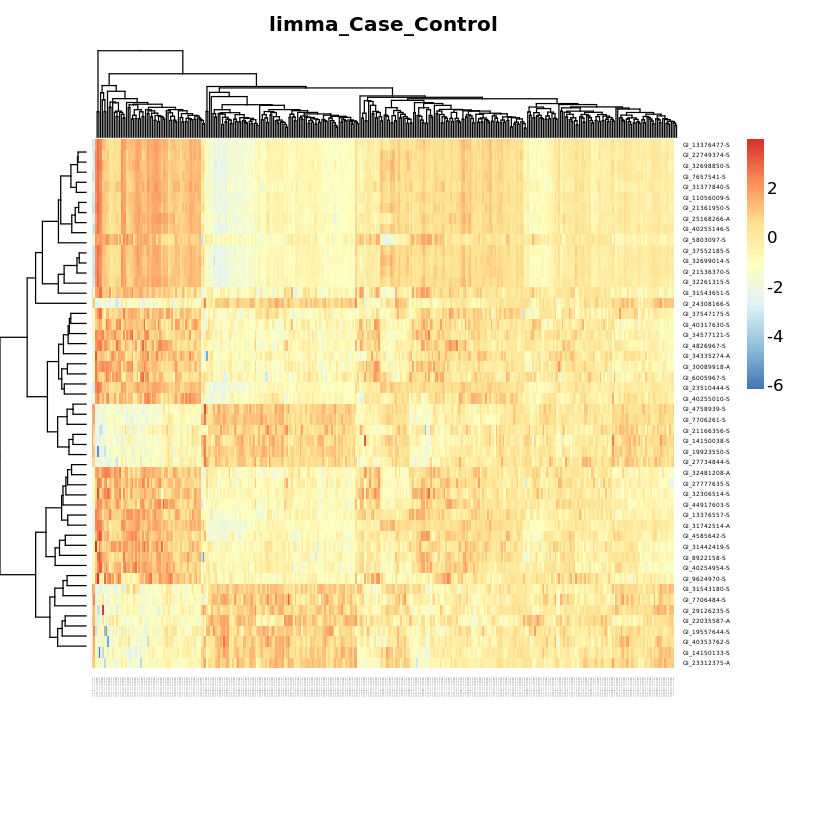

In [8]:
#input.path="" # We are providing the dataset objects but the input path and file names are possible. Internally the function uses read.table(paste(input.path,clinicalset,sep="/"),check.names = F)
output.path="/mnt/data/GWES/Microarray/output/GSE15222/"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "Case",DE.cond2 = "Control",DE.variable = "diagnosis",DE.covariates=c("sex","age"),output.path,platform = "2700")


**Case versus Control in a subset of only females - corrected for age**


####  Case  versus  Control  ####

## Subset  sex Female  ##


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  336 5
dim(expr)  9592 336
Subseting datasets to keep those subjects belonging to provided conditions:  Case  and  Control
dim(clinical.subset)  336 5
dim(expr.subset)  9592 336
Subseting datasets by  Female
dim(clinical.subset)  158 5
dim(expr.subset)  9592 158

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]

design matrix: 
  Case Control clinicalset..DE.covariates.1...
1    0       1                              85
2    0       1                              73
3    0       1                              83


contrast:  Case-Control 


limma topTable: 
                   logFC       CI.L       CI.R  AveExpr         t      P.Value    adj.P.Val        B
GI_23312375-A -1.1497119 -1.3894596 -0.9099642 6.200536 -9.470890 3.657962e-17 3.508717e-13 28.41084
GI_24308166-S -0.9041854 -1.0988936 -0.7094771 9.703212 -9.171268 2.275595e-16 1.091375e-12 26.63907
GI_31543180-S -0.9619904 -1.1708266 -0.7531541 7.312681 -9.09747

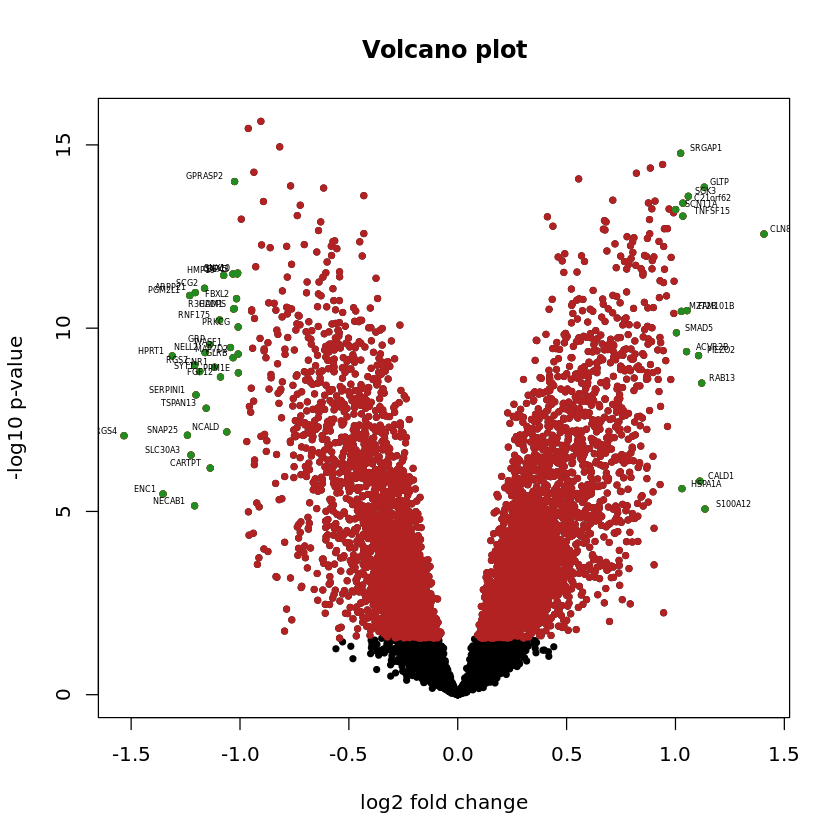

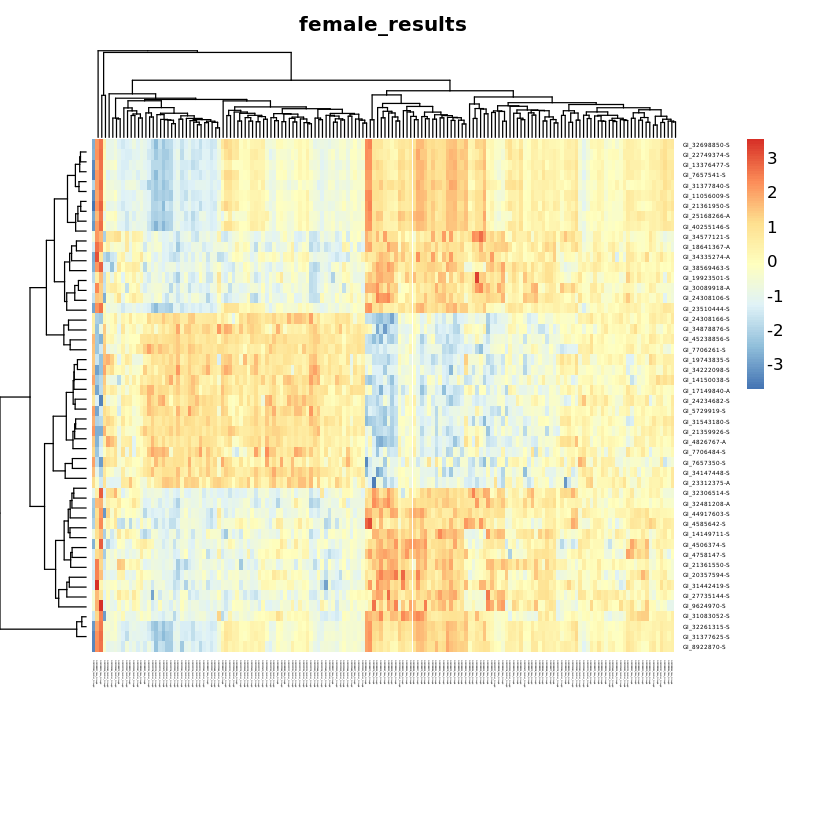

In [10]:
#input.path=""
output.path="/mnt/data/GWES/Microarray/output/GSE15222/"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "Case",DE.cond2 = "Control",DE.variable = "diagnosis",DE.covariates=c("age"),subset.variable = "sex", subset.value = "Female",output.path,out.name = "female_results",platform = "2700")


**APOE group 2 versus group 3 - corrected for age and sex**


####  Group2  versus  Group3  ####


Warning message in if (class(expression) == "character") {:
"the condition has length > 1 and only the first element will be used"



dim(clinicalset)  336 5
dim(expr)  9592 336
Subseting datasets to keep those subjects belonging to provided conditions:  Group2  and  Group3
dim(clinical.subset)  191 5
dim(expr.subset)  9592 191

== Doing limma == 

model formula:  ~0 + clinicalset[[DE.variable]]+clinicalset[[DE.covariates[1]]]+clinicalset[[DE.covariates[2]]]

design matrix: 
  Group2 Group3 clinicalset..DE.covariates.1...Male clinicalset..DE.covariates.2...
1      0      1                                   1                              85
2      0      1                                   1                              85
3      0      1                                   1                              79


contrast:  Group2-Group3 


limma topTable: 
                   logFC       CI.L        CI.R  AveExpr         t      P.Value adj.P.Val         B
GI_14249451-S -0.2962779 -0.4572653 -0.13529041 5.402596 -3.629986 0.0003635540 0.9098219 -1.620643
GI_34365798-S -0.2084378 -0.3231298 -0.09374584 8.525231 -3.584605 0.0

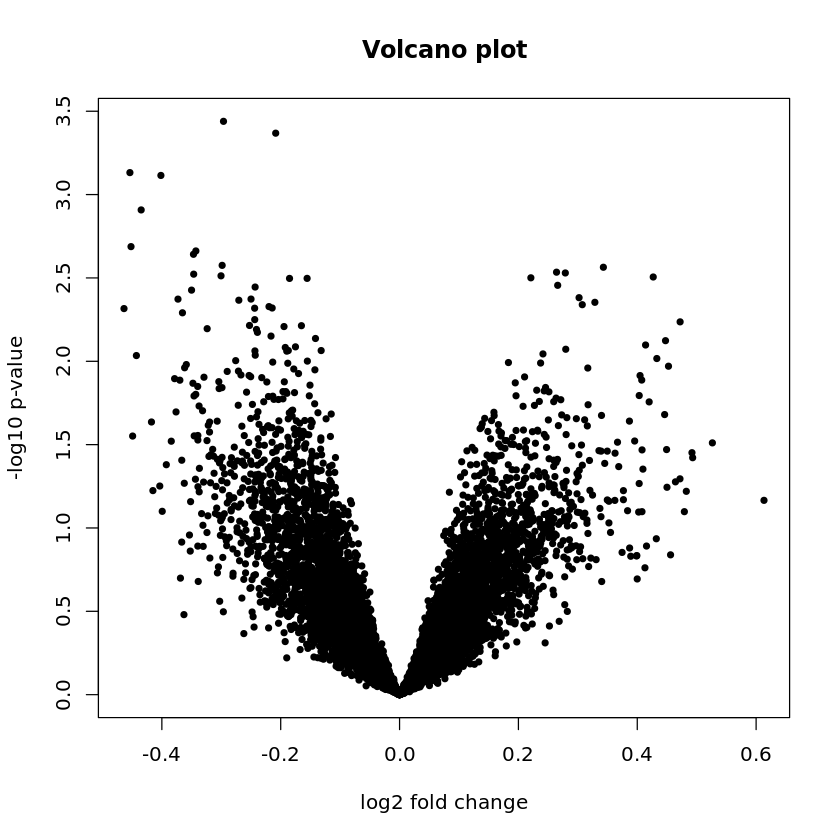

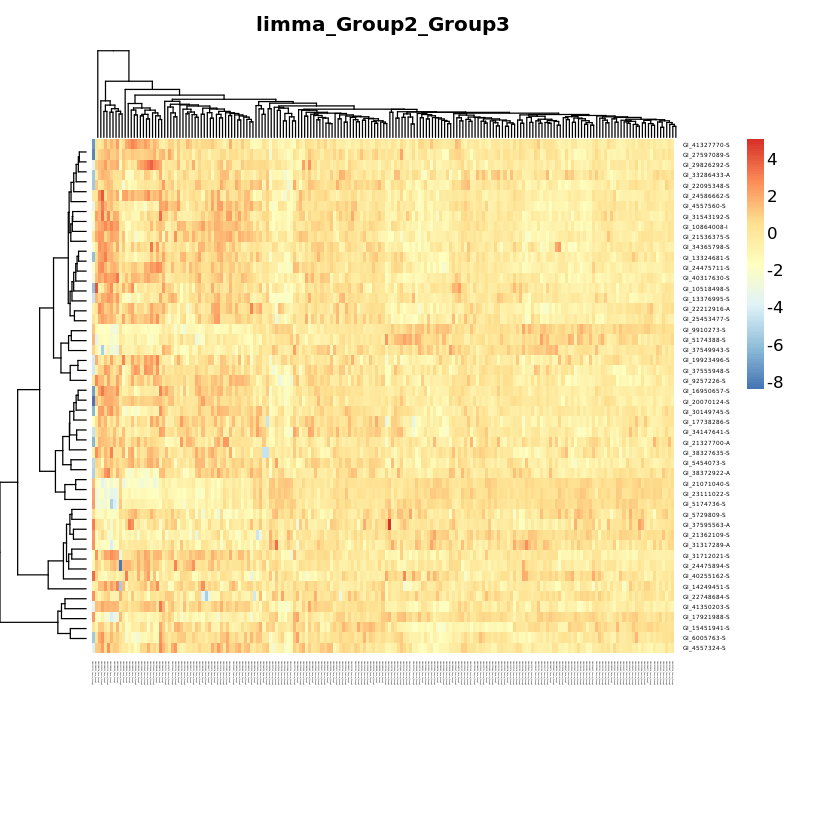

In [11]:
output.path="/mnt/data/GWES/Microarray/output/GSE15222/"
diff_analysis_function(clinicalset = clinicalset.common,expression = expr.common,DE.cond1 = "Group2",DE.cond2 = "Group3",DE.variable = "APOEgroup",DE.covariates=c("sex","age"),output.path,platform = "2700")
